# Aplikasi Prediksi Diabetes Berbasis Web dengan Streamlit

## Siane Santoso
## A11.2022.13956

### Ringkasan Masalah

### Tujuan 

### Bagan

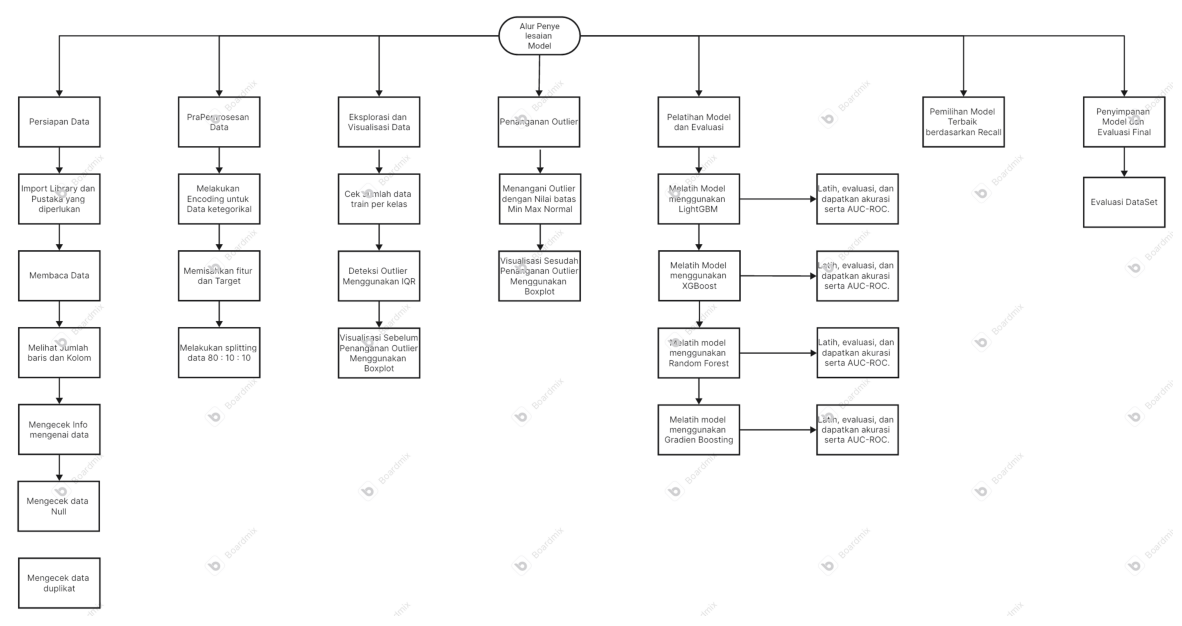

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('flowchart.png') 

# Mengatur ukuran gambar
plt.figure(figsize=(15, 11))  


plt.imshow(img)
plt.axis('off')  
plt.show()


### Penjelasan Dataset

In [118]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, make_scorer, recall_score, f1_score, roc_auc_score, precision_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

import pickle

In [120]:
# baca data file dengan bentuk csv
df = pd.read_csv("diabetes_prediction_dataset.csv")

In [122]:
#jumlah baris dan kolom dari dataset
df.shape

(100000, 9)

In [124]:
# hapus data duplikat
df.drop_duplicates(inplace=True)

In [126]:
# cek data null di setiap kolom 
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [128]:
# cek info data (tipe data per kolom) 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96146 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               96146 non-null  object 
 1   age                  96146 non-null  float64
 2   hypertension         96146 non-null  int64  
 3   heart_disease        96146 non-null  int64  
 4   smoking_history      96146 non-null  object 
 5   bmi                  96146 non-null  float64
 6   HbA1c_level          96146 non-null  float64
 7   blood_glucose_level  96146 non-null  int64  
 8   diabetes             96146 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 7.3+ MB


In [130]:
# lakukan encoding untuk data kategorical 
df = pd.get_dummies(df, columns=['gender'], prefix='gender')
df = pd.get_dummies(df, columns=['smoking_history'], prefix='smoking_history')

df[['gender_Female', 'gender_Male', 'gender_Other']] = df[['gender_Female', 'gender_Male', 'gender_Other']].astype(int)
df[['smoking_history_No Info', 'smoking_history_current', 'smoking_history_ever',
     'smoking_history_former', 'smoking_history_never', 'smoking_history_not current']] = df[[
    'smoking_history_No Info', 'smoking_history_current', 'smoking_history_ever',
    'smoking_history_former', 'smoking_history_never', 'smoking_history_not current']].astype(int)

In [132]:
# cek lagi info data 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96146 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          96146 non-null  float64
 1   hypertension                 96146 non-null  int64  
 2   heart_disease                96146 non-null  int64  
 3   bmi                          96146 non-null  float64
 4   HbA1c_level                  96146 non-null  float64
 5   blood_glucose_level          96146 non-null  int64  
 6   diabetes                     96146 non-null  int64  
 7   gender_Female                96146 non-null  int32  
 8   gender_Male                  96146 non-null  int32  
 9   gender_Other                 96146 non-null  int32  
 10  smoking_history_No Info      96146 non-null  int32  
 11  smoking_history_current      96146 non-null  int32  
 12  smoking_history_ever         96146 non-null  int32  
 13  smoking_history_forme

In [134]:
# lihat beberapa data 
df.head(5)

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,6.6,140,0,1,0,0,0,0,0,0,1,0
1,54.0,0,0,27.32,6.6,80,0,1,0,0,1,0,0,0,0,0
2,28.0,0,0,27.32,5.7,158,0,0,1,0,0,0,0,0,1,0
3,36.0,0,0,23.45,5.0,155,0,1,0,0,0,1,0,0,0,0
4,76.0,1,1,20.14,4.8,155,0,0,1,0,0,1,0,0,0,0


In [136]:
# lihat ukuran baris dan kolom data 
df.shape

(96146, 16)

### Proses Features Data

In [139]:
# pisahkan fitur dan target
# target disini adalah kolom diabetes
X = df.drop('diabetes', axis=1)
y = df['diabetes']

In [141]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

### Penjelasan EDA

In [144]:
# cek keseimbangan data 
print(y_train.value_counts())

diabetes
0    70130
1     6786
Name: count, dtype: int64


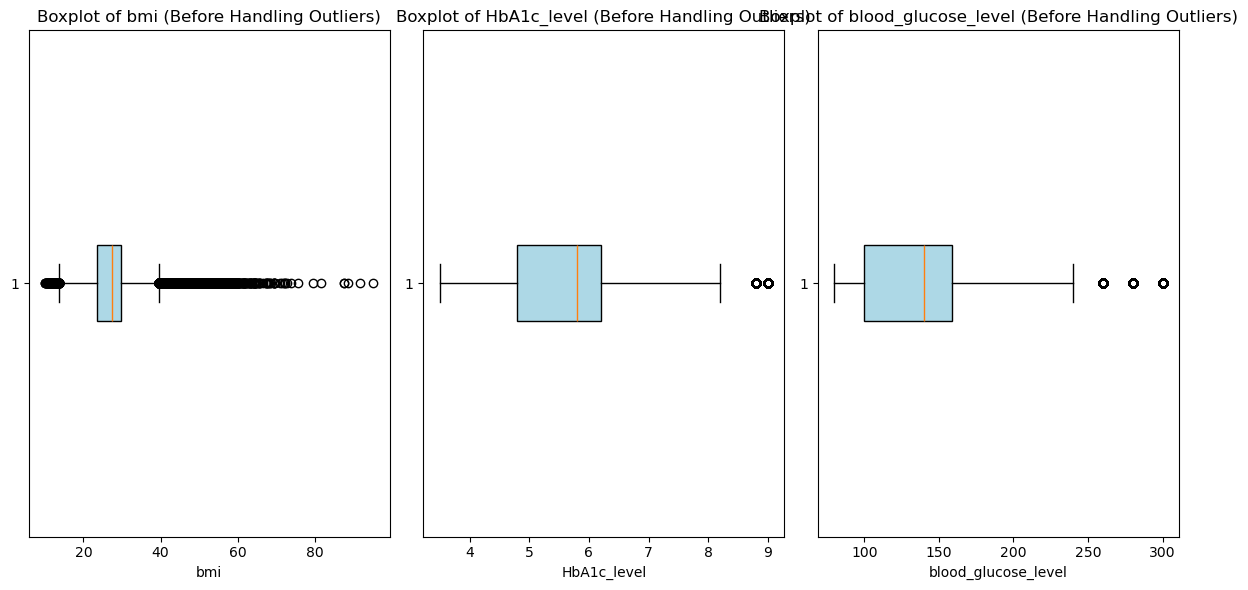

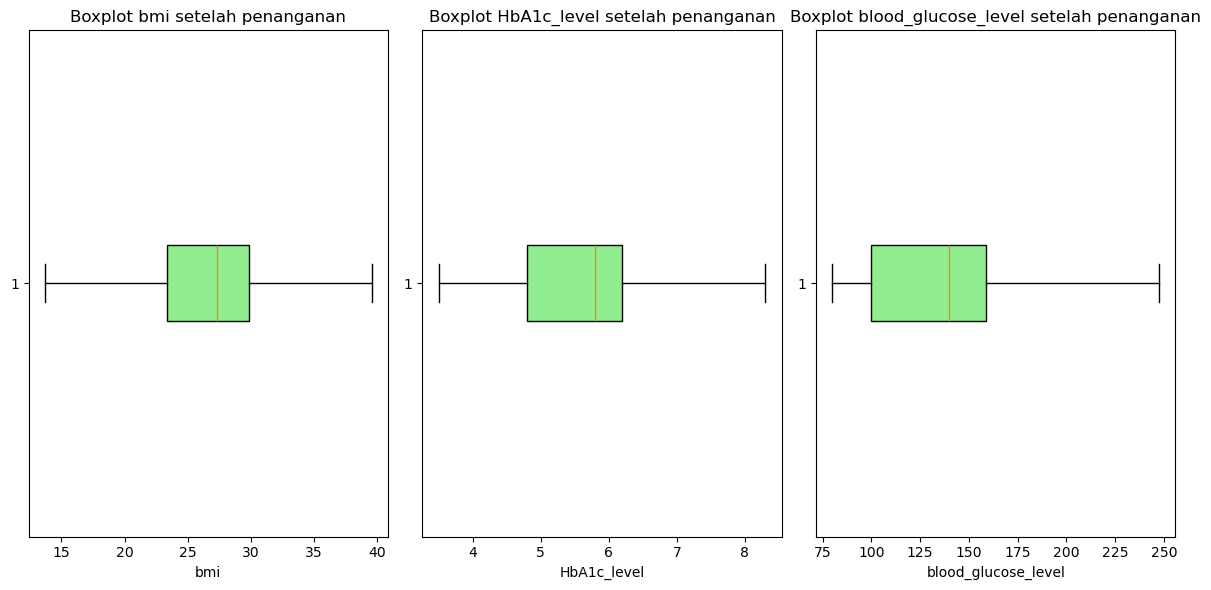

In [146]:
# Fungsi untuk mendeteksi outlier menggunakan IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data[column] < lower_bound) | (data[column] > upper_bound)

# Fungsi untuk menangani outlier dengan mengganti nilai outlier ke batas minimum atau maksimum normal
def handle_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Ganti nilai outlier
    data[column] = np.where(data[column] < lower_bound, lower_bound, data[column])
    data[column] = np.where(data[column] > upper_bound, upper_bound, data[column])

# Pastikan X_train adalah DataFrame, dan kolom yang relevan ada dalam X_train
columns_to_check = ["bmi", "HbA1c_level", "blood_glucose_level"]

# Visualisasi sebelum penanganan outlier
plt.figure(figsize=(12, 6))
for i, column in enumerate(columns_to_check, 1):
    plt.subplot(1, 3, i)
    plt.boxplot(X_train[column], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    plt.title(f'Boxplot of {column} (Before Handling Outliers)')
    plt.xlabel(column)

plt.tight_layout()
plt.show()

# Terapkan penanganan outlier untuk kolom bmi, HbA1c_level, dan blood_glucose_level pada X_train
for column in columns_to_check:
    handle_outliers_iqr(X_train, column)

# Visualisasi setelah penanganan outlier
plt.figure(figsize=(12, 6))
for i, column in enumerate(columns_to_check, 1):
    plt.subplot(1, 3, i)
    plt.boxplot(X_train[column], vert=False, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
    plt.title(f'Boxplot {column} setelah penanganan')
    plt.xlabel(column)

plt.tight_layout()
plt.show()

### Proses Learning Model

In [150]:
# Train Menggunakan LGBM model
modelLGBM = LGBMClassifier(random_state=42)
modelLGBM.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6786, number of negative: 70130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 76916, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088226 -> initscore=-2.335489
[LightGBM] [Info] Start training from score -2.335489


LGBMClassifier(random_state=42)

In [166]:
# Evaluasi data val menggunakan LGBM
val_predictions = modelLGBM.predict(X_val)
print("Prediksi Data Validasi")
print("Metriks Validasi:\n", classification_report(y_val, val_predictions))
print("Akurasi Validasi:", accuracy_score(y_val, val_predictions))
print("Confusion Matrix Validasi:\n", confusion_matrix(y_val, val_predictions))

# Hitung skor AUC-ROC
auc_score = roc_auc_score(y_val, val_predictions)
print("AUC-ROC Score Validasi:", auc_score)

Prediksi Data Validasi
Metriks Validasi:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99      8767
           1       0.98      0.72      0.83       848

    accuracy                           0.97      9615
   macro avg       0.98      0.86      0.91      9615
weighted avg       0.97      0.97      0.97      9615

Akurasi Validasi: 0.9736869474778991
Confusion Matrix Validasi:
 [[8754   13]
 [ 240  608]]
AUC-ROC Score Validasi: 0.8577491493615638


In [168]:
# Train XGBoost model
modelXGBoost = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
modelXGBoost.fit(X_train, y_train)

C:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:36:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [170]:
# Evaluasi data val menggunakan XGBoost
val_predictions = modelXGBoost.predict(X_val)
print("Prediksi Data Validasi")
print("Metriks Validasi:\n", classification_report(y_val, val_predictions))
print("Akurasi Validasi:", accuracy_score(y_val, val_predictions))
print("Confusion Matrix Validasi:\n", confusion_matrix(y_val, val_predictions))

# Hitung skor AUC-ROC
auc_score = roc_auc_score(y_val, val_predictions)
print("AUC-ROC Score Validasi:", auc_score)

Prediksi Data Validasi
Metriks Validasi:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99      8767
           1       0.96      0.72      0.82       848

    accuracy                           0.97      9615
   macro avg       0.97      0.86      0.91      9615
weighted avg       0.97      0.97      0.97      9615

Akurasi Validasi: 0.9729589183567343
Confusion Matrix Validasi:
 [[8743   24]
 [ 236  612]]
AUC-ROC Score Validasi: 0.8594802873554561


In [172]:
# Train Random Forest 
modelRF = RandomForestClassifier(n_estimators=100, random_state=42, class_weight = "balanced")
modelRF.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [173]:
# Evaluasi data val menggunakan Random Forest
val_predictions = modelRF.predict(X_val)
print("Prediksi Data Validasi")
print("Metriks Validasi:\n", classification_report(y_val, val_predictions))
print("Akurasi Validasi:", accuracy_score(y_val, val_predictions))
print("Confusion Matrix Validasi:\n", confusion_matrix(y_val, val_predictions))

# Hitung skor AUC-ROC
auc_score = roc_auc_score(y_val, val_predictions)
print("AUC-ROC Score Validasi:", auc_score)

Prediksi Data Validasi
Metriks Validasi:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      8767
           1       0.95      0.71      0.81       848

    accuracy                           0.97      9615
   macro avg       0.96      0.85      0.90      9615
weighted avg       0.97      0.97      0.97      9615

Akurasi Validasi: 0.9711908476339054
Confusion Matrix Validasi:
 [[8733   34]
 [ 243  605]]
AUC-ROC Score Validasi: 0.8547826083447577


In [174]:
# Train Gradient Boosting 
modelGB = GradientBoostingClassifier(n_estimators=100, random_state=42)
modelGB.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [175]:
# Evaluasi data val menggunakan Gradien Boosting
val_predictions = modelGB.predict(X_val)
print("Prediksi Data Validasi")
print("Metriks Validasi:\n", classification_report(y_val, val_predictions))
print("Akurasi Validasi:", accuracy_score(y_val, val_predictions))
print("Confusion Matrix Validasi:\n", confusion_matrix(y_val, val_predictions))

# Hitung skor AUC-ROC
auc_score = roc_auc_score(y_val, val_predictions)
print("AUC-ROC Score Validasi:", auc_score)

Prediksi Data Validasi
Metriks Validasi:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99      8767
           1       0.99      0.71      0.83       848

    accuracy                           0.97      9615
   macro avg       0.98      0.86      0.91      9615
weighted avg       0.97      0.97      0.97      9615

Akurasi Validasi: 0.9741029641185648
Confusion Matrix Validasi:
 [[8761    6]
 [ 243  605]]
AUC-ROC Score Validasi: 0.8563795058011282


### Performa Model

In [183]:
# Daftar model yang sudah dilatih
# karna dalam diabetes lebih penting untuk meminimalisir false positif

models = {
    'LGBM': modelLGBM,
    'XGBoost': modelXGBoost,
    'Random Forest': modelRF,
    'Gradien Boosting': modelGB
}

# Variabel untuk menyimpan model terbaik
best_model = None
best_recall = 0

# Loop untuk mengevaluasi setiap model berdasarkan Recall
for name, model in models.items():
    # Prediksi menggunakan data validasi
    y_pred = model.predict(X_val)
    
    # Hitung Recall
    recall = recall_score(y_val, y_pred)
    
    # Print hasil evaluasi
    print(f"{name} -> Recall: {recall:.4f}")
    
    # Simpan model dengan Recall terbaik
    if recall > best_recall:
        best_recall = recall
        best_model = model

print("\nModel terbaik berdasarkan Recall:", best_model)


LGBM -> Recall: 0.7170
XGBoost -> Recall: 0.7217
Random Forest -> Recall: 0.7134
Gradien Boosting -> Recall: 0.7134

Model terbaik berdasarkan Recall: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)


In [185]:
# Simpan model terbaik dan pastikan sudah dilatih
if best_model is not None:
    with open('best_model.pkl', 'wb') as file:
        pickle.dump(best_model, file)
    print("Model terbaik telah disimpan sebagai 'best_model.pkl'")
else:
    print("Tidak ada model yang disimpan. Pastikan semua model telah dilatih.")

Model terbaik telah disimpan sebagai 'best_model.pkl'


In [187]:
# mual model untuk evaluasi data test
# Muat model dari file .pkl
with open('best_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [189]:
# Evaluasi data test menggunakan XGBoost
test_predictions = loaded_model.predict(X_test)
print("Prediksi Data Test")
print("Metriks Validasi:\n", classification_report(y_test, test_predictions))
print("Akurasi Validasi:", accuracy_score(y_test, test_predictions))
print("Confusion Matrix Validasi:\n", confusion_matrix(y_test, test_predictions))

Prediksi Data Test
Metriks Validasi:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      8767
           1       0.94      0.67      0.78       848

    accuracy                           0.97      9615
   macro avg       0.96      0.83      0.88      9615
weighted avg       0.97      0.97      0.96      9615

Akurasi Validasi: 0.9672386895475819
Confusion Matrix Validasi:
 [[8734   33]
 [ 282  566]]


### Diskusi Hasil dan Kesimpulan